<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-1">CatBoost</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Now-lets-do-catBoost" data-toc-modified-id="Now-lets-do-catBoost-1.0.1">Now lets do catBoost</a></span></li><li><span><a href="#very-good-test-score-of-95.3%" data-toc-modified-id="very-good-test-score-of-95.3%-1.0.2">very good test score of 95.3%</a></span></li></ul></li></ul></li></ul></div>

## CatBoost

**CatBoost** is a new Gradient boosting library. **CatBoost** is shown to be better than **LightGBM** and **xgBoost** on some tasks. Below are some innovations in **CatBoost**.

**CatBoost** paper: https://arxiv.org/abs/1706.09516

1. **CatBoost** tried to address *prediction shift* caused by target leakage, they came up with a novel ordered boosting algorithm to address this issue.
2. They applied the same ordered statistics methods to handle categorical features. In **CatBoost** there is no need for on-hot-encoding of categorical features.

Lets understand *target leakage* a little more. One common trick for handling categorical features is called **Target Statistics (TS)**. In TS what we do is we substitute the category $x^i_k$ of the $k-th$ training example with one numeric feature equal to some target statistics (TS) $\hat{x}^i_k$. Commonly, it estimates the expected target $y$ conditioned by category: $\hat{x}^i_k=E(y|x^i = x^i_k)$. A straightforward approach to estimate $\hat{x}^i_k=E(y|x^i = x^i_k)$ is the average value of $y$ over the training examples with the same category $x_k^i$. Problem with this is feature $x_k^i$ is computed using $y_k$, the target of $x_k$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Make the sheet width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>" ))

In [2]:
from catboost import datasets
train_df, test_df = datasets.amazon()
print(train_df.shape, test_df.shape)


(32769, 10) (58921, 10)


In [3]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
#Lets list all the categorical columns
categorical_columns = train_df.drop('ACTION', axis=1).columns
print(categorical_columns)

Index(['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'],
      dtype='object')


In [5]:
#Lets apply Logistic Regression, RandomForest, xgBoost, LightGBM and catBoost to the data
#For other methods except catBoost we need to have one hot encoding
#Now lets apply one hot encoding to categorical columns
def applyOneHot(df, cat_columns):
    onehot_df = df[cat_columns]
    onehot_df = pd.get_dummies(onehot_df, columns = cat_columns)
    onehot_drop = df.drop(cat_columns, axis = 1)
    ret = pd.concat([onehot_drop, onehot_df], axis = 1)
    return ret

train_df_one_hot = applyOneHot(train_df, categorical_columns)
print(train_df_one_hot.shape)

(32769, 15627)


In [6]:
y = train_df_one_hot['ACTION']
X = train_df_one_hot.drop('ACTION', axis=1)

In [7]:
#Lets use 25% of the data as test because train data is unlabled
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [8]:
%%time
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=500)
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

Train score=0.959
Test score=0.948
CPU times: user 1min 56s, sys: 11.9 s, total: 2min 8s
Wall time: 1min 31s


In [9]:
%%time
#Lets apply random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, min_samples_split=2)
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

Train score=1.0
Test score=0.951
CPU times: user 20min 8s, sys: 11.3 s, total: 20min 19s
Wall time: 21min 50s


In [20]:
%%time
#Lets apply xgBoost default parameters
import xgboost as xgb
clf = xgb.XGBClassifier(tree_method='hist')
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

Train score=0.97
Test score=0.949
CPU times: user 987 ms, sys: 49.3 ms, total: 1.04 s
Wall time: 350 ms


In [25]:
%%time
#Lets apply LightGBM
import lightgbm as lgb
clf = lgb.LGBMClassifier(boosting_type='goss')
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

Train score=0.957
Test score=0.947
CPU times: user 1.36 s, sys: 38.2 ms, total: 1.4 s
Wall time: 450 ms


#### Now lets do catBoost

In [12]:
y = train_df['ACTION']
X = train_df.drop('ACTION', axis=1)

In [13]:
#Lets use 25% of the data as test because train data is unlabled
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#and 25% of train data as validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [23]:
%%time
from catboost import CatBoostClassifier 
clf = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    cat_features=categorical_columns,
    early_stopping_rounds=200,
    verbose=200,
    random_seed=1
)
clf.fit(X_train, y_train, 
        eval_set=(X_valid, y_valid), 
        use_best_model=True)


Learning rate set to 0.065089
0:	test: 0.5895970	best: 0.5895970 (0)	total: 21.2ms	remaining: 21.1s
200:	test: 0.8828906	best: 0.8830745 (190)	total: 12.5s	remaining: 49.9s
400:	test: 0.8843996	best: 0.8845600 (383)	total: 27.1s	remaining: 40.5s
600:	test: 0.8839381	best: 0.8852154 (452)	total: 38s	remaining: 25.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8852153871
bestIteration = 452

Shrink model to first 453 iterations.
CPU times: user 1min 20s, sys: 15.9 s, total: 1min 36s
Wall time: 40.9 s


In [24]:
print(f"Train score={clf.score(X, y):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

Train score=0.969
Test score=0.953


#### very good test score of 95.3%

In the above tests we can see that **catBoost** gave one of the best performance. But it also took much longer.

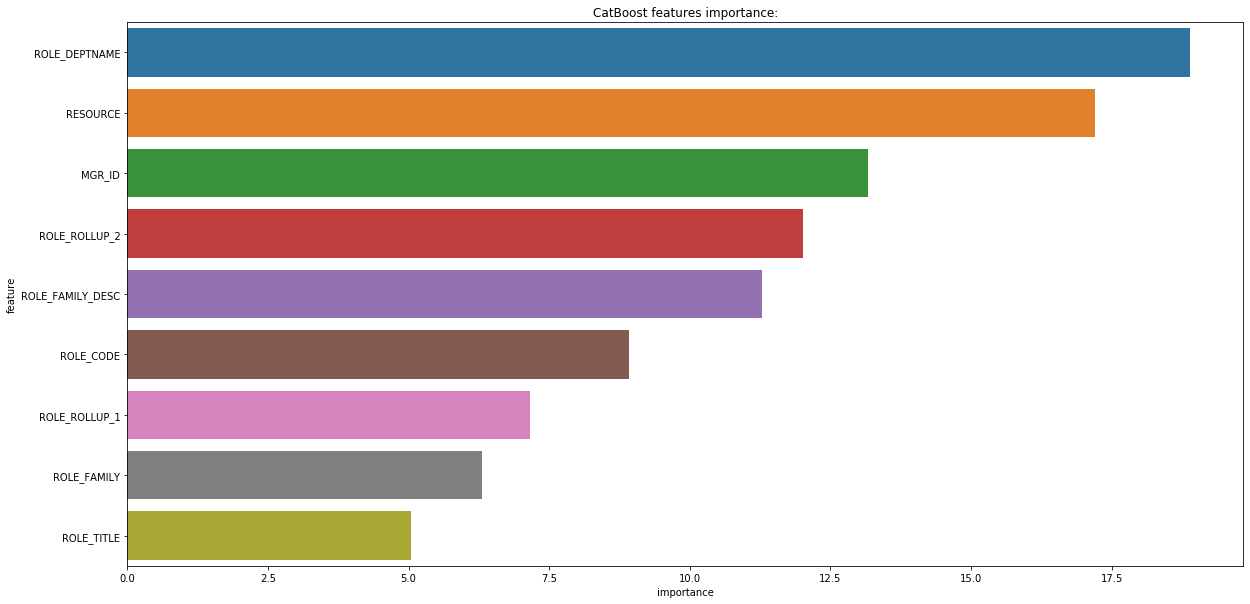

In [18]:
#Lets look at feature importance
import seaborn as sns

feature_importance_df = pd.DataFrame(clf.get_feature_importance(prettified=True).values, 
                                     columns=['feature', 'importance'])


plt.figure(figsize=(20, 10));
sns.barplot(x="importance", y="feature", data=feature_importance_df);
plt.title('CatBoost features importance:');